## Machine learning on Social Netowrk Graphs





Notre projet  pour l'analyse de graphes de réseaux sociaux en utilisant des techniques d'apprentissage automatique.
Il est structuré en plusieurs sections, couvrant divers aspects de l'analyse de réseaux et de l'apprentissage automatique. Voici un résumé de chaque section :

Introduction et Téléchargement des Données : Cette section importe les bibliothèques nécessaires et télécharge le jeu de données du graphe social de Facebook. Elle décompresse ensuite et examine le contenu des fichiers téléchargés.

* Aperçu des Données : Il charge le réseau combiné à l'aide de NetworkX, ainsi que les réseaux d'ego individuels et leurs caractéristiques.

* Visualisation du Réseau : Le code fournit une fonction pour dessiner le graphe avec certaines métriques, et visualise également la disposition globale du réseau.

* Analyse du Réseau : Cette section comprend des fonctions pour dessiner des graphes en fonction de différentes métriques (comme la centralité d'intermédiarité) et une méthode pour résumer les statistiques du réseau. Il y a aussi du code pour tracer des histogrammes de diverses mesures de centralité.

* Détection de Communautés : Utilise l'algorithme de Louvain pour détecter des communautés dans le graphe et visualise ces communautés.

* Analyse de Réseau d'Ego : Se concentre sur l'analyse de sous-réseaux d'utilisateurs d'ego individuels, en chargeant leurs caractéristiques de réseau spécifiques et leurs cercles.

* Encastrements pour Tâches Supervisées et Non Supervisées : Discute de la préparation des caractéristiques des nœuds pour les tâches d'apprentissage automatique, en particulier pour la prédiction de liens.

* Prédiction de Liens : Compare différentes méthodes (node2vec, graphSAGE et caractéristiques fabriquées à la main) pour prédire les arêtes manquantes dans le graphe.

In [ ]:
import os
import math
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In [ ]:
import networkx as nx
from networkx.algorithms import approximation
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby

import statistics

%matplotlib inline

Dans ce notebook, nous nous concentrerons sur l'utilisation des techniques décrites pour analyser l'exemple le plus courant des graphes actuels : les réseaux sociaux. En particulier, nous appliquerons les techniques décrites dans les chapitres précédents pour étudier les propriétés topologiques des réseaux, telles que

1. l'identification des communautés pertinentes ainsi que
2. l'identification des nœuds particulièrement importants dans le réseau.

Nous utiliserons ensuite les encastrements de nœuds pour tirer parti de la puissance des informations topologiques pour différentes tâches, telles que la prédiction de liens (en tant que moteur de recommandation potentiel pour les nouveaux amis).



```
# Ce texte est au format code
```

#### Télécharger le jeu de données

Tout d'abord, nous devons télécharger le jeu de données. Nous utiliserons le [SNAP Facebook social graph] (http://snap.stanford.edu). L'ensemble de données a été créé en collectant des informations sur les utilisateurs de Facebook auprès des participants à l'enquête.  Plus précisément, 10 ego-networks ont été créés à partir de 10 utilisateurs. Il a été demandé à chaque utilisateur d'identifier tous les cercles (liste d'amis) auxquels appartiennent ses amis. Ensuite, tous les "ego-network" ont été combinés en un seul graphe.

In [ ]:
!wget http://snap.stanford.edu/data/facebook_combined.txt.gz
!wget http://snap.stanford.edu/data/facebook.tar.gz
!gzip -d facebook_combined.txt.gz
!tar -xf facebook.tar.gz

--2023-12-12 23:46:56--  http://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   442KB/s    in 0.5s    

2023-12-12 23:46:56 (442 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]

--2023-12-12 23:46:56--  http://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K   872KB/s    in 0.8s    

2023-12-12 23:46:57 (872 KB/s) - ‘facebook.tar.gz’ saved [732

### Aperçu de l'ensemble de données
---



Le code ci-dessus télécharge deux fichiers principaux :
* un fichier texte contenant la liste des arêtes du graphe. Le graphe est en fait créé
* une archive contenant un dossier ("facebook") avec toutes les informations relatives à chaque réseau d'ego.

In [ ]:
# vérifier le contenu téléchargé
!ls

facebook  facebook_combined.txt  facebook.tar.gz  sample_data


In [ ]:
# les premières lignes de la liste des bords
!head facebook_combined.txt

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10


Nous pouvons maintenant charger le réseau combiné à l'aide de networkx. Nous allons également charger le nodeId du 10 "ego-user"

In [ ]:
# Lecture du fichier "facebook_combined.txt" et création d'un graphe G en utilisant nx.Graph()
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)


In [ ]:
# Ouverture des fichiers du jeu de données "facebook"
f0circles = open("facebook/0.circles")
f0edges = open("facebook/0.edges")
f0egofeat = open("facebook/0.egofeat")
f0feat = open("facebook/0.feat")
f0featnames = open("facebook/0.featnames")

# Lecture des lignes du fichier "0.feat"
f0featlines = f0feat.readlines()


In [ ]:
# Ouverture du fichier "0.feat"
f = open("facebook/0.feat")

# Initialisation d'une liste pour stocker les caractéristiques
features = []

# Lecture des lignes du fichier
for line in f:
    # Suppression des espaces blancs au début et à la fin de la ligne
    line = line.strip()

    # Fractionnement de la ligne sur l'espace
    line = line.split(" ")

    # Conversion des éléments de la ligne en entiers
    for i in range(len(line)):
        line[i] = int(line[i])

    # Ajout des caractéristiques à la liste des caractéristiques sous forme de matrice creuse
    features.append(sp.csr_matrix(line[1:], dtype=np.float32))

# Création d'un dictionnaire vide pour stocker les caractéristiques
vis = {}

# Affichage de la longueur de la liste des caractéristiques
print(len(features))


347


In [ ]:
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

Number of nodes 4039
Number of edges 88234
Average degree 43.69101262688784


In [ ]:
#print(nx.info(G))

In [ ]:
# Chaque fichier du répertoire "facebook" est nommé nodeId.format.
# où nodeId est l'identifiant d'un ego-user et format est le format du fichier
ego_nodes = set([int(name.split('.')[0]) for name in os.listdir("facebook/")])
ego_nodes

{0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980}

os.listdir("facebook/") : Cette fonction liste tous les noms de fichiers dans le répertoire nommé "facebook".

for name in os.listdir("facebook/") : C'est une boucle qui itère sur chaque nom de fichier dans le répertoire "facebook".

name.split('.')[0] : Cela divise chaque nom de fichier au point ('.') et prend la première partie (indice 0), qui est supposée être l'identifiant du nœud ego dans le format nodeId.format.

int(...) : Cela convertit l'identifiant du nœud de chaîne en entier.

ego_nodes = set(...) : Cela crée un ensemble de ces identifiants de nœuds. L'utilisation d'un ensemble

Let's visualize the network for a deeper understanding

In [ ]:
#Créer une structure de réseau pour les visualisations
spring_pos = nx.spring_layout(G)
spring_pos

{0: array([0.20791411, 0.48856279]),
 1: array([0.21884899, 0.46445513]),
 2: array([0.22190297, 0.6236887 ]),
 3: array([0.18721877, 0.47643071]),
 4: array([0.28282568, 0.59141266]),
 5: array([0.21243925, 0.43405902]),
 6: array([0.31473124, 0.59091866]),
 7: array([0.11169409, 0.37334555]),
 8: array([0.19687375, 0.63528252]),
 9: array([0.17163233, 0.4295716 ]),
 10: array([0.13998669, 0.46389589]),
 11: array([0.25598559, 0.65058875]),
 12: array([0.31141534, 0.61267912]),
 13: array([0.15197487, 0.45042476]),
 14: array([0.23232989, 0.619555  ]),
 15: array([0.22258152, 0.65570766]),
 16: array([0.17318229, 0.51065421]),
 17: array([0.24802144, 0.62350041]),
 18: array([0.18251432, 0.63879251]),
 19: array([0.2671563 , 0.61228907]),
 20: array([0.23281604, 0.63593262]),
 21: array([0.16471128, 0.41372725]),
 22: array([0.13542472, 0.42186138]),
 23: array([0.23509109, 0.58786207]),
 24: array([0.27180773, 0.49897107]),
 25: array([0.17748129, 0.46325132]),
 26: array([0.16385667

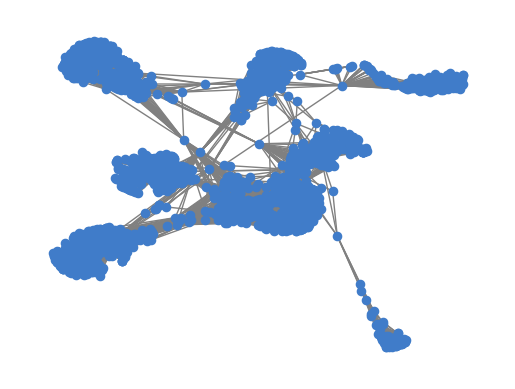

In [ ]:
plt.axis("off")
# Dessin du réseau
nx.draw_networkx(G, pos=spring_pos, node_color=default_node_color, edge_color=default_edge_color, with_labels=False, node_size=35)

nx.draw_networkx(G, pos=spring_pos, node_color=default_node_color, edge_color=default_edge_color, with_labels=False, node_size=35) : Cette ligne de code est une fonction de NetworkX pour dessiner le graphe G. Les paramètres incluent la position des nœuds (pos=spring_pos), la couleur des nœuds et des arêtes, l'option d'afficher ou non les étiquettes des nœuds (with_labels=False), et la taille des nœuds (node_size=35). Cette fonction rend le graphe basé sur les données et les paramètres fournis.

### Network Analysis

In [ ]:
def draw_metric(G, dct, spring_pos):
  """ Dessiner le graphe G en utilisant la disposition spring_pos.
      Les 10 nœuds supérieurs par rapport aux valeurs dans le dictionnaire dct
      sont mis en évidence dans la visualisation """

  top = 10  # Nombre de nœuds supérieurs à mettre en évidence
  max_nodes =  sorted(dct.items(), key = lambda v: -v[1])[:top]  # Tri et sélection des 10 nœuds supérieurs selon dct

  max_keys = [key for key,_ in max_nodes]  # Extraire les identifiants des nœuds supérieurs
  max_vals = [val*300 for _, val in max_nodes]  # Ajuster la taille des nœuds supérieurs pour la visualisation

  plt.axis("off")  # Désactiver les axes pour une visualisation propre

  # Dessiner le graphe avec des paramètres par défaut
  nx.draw_networkx(G,
                   pos=spring_pos,
                   cmap='Blues',
                   edge_color=default_edge_color,
                   node_color=default_node_color,
                   node_size=3,
                   alpha=0.4,
                   with_labels=False)

  # Dessiner spécifiquement les nœuds supérieurs avec des paramètres améliorés
  nx.draw_networkx_nodes(G,
                         pos=spring_pos,
                         nodelist=max_keys,
                         node_color=enhanced_edge_color,
                         node_size=max_vals)

In [ ]:
# betweenness centrality
bC = nx.betweenness_centrality(G)
np.mean(list(bC.values()))

0.0006669573568730229

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


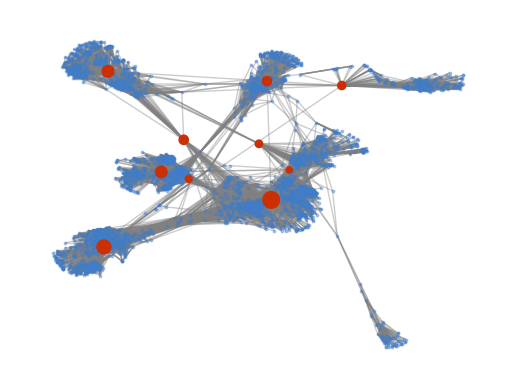

In [ ]:
draw_metric(G,bC,spring_pos)

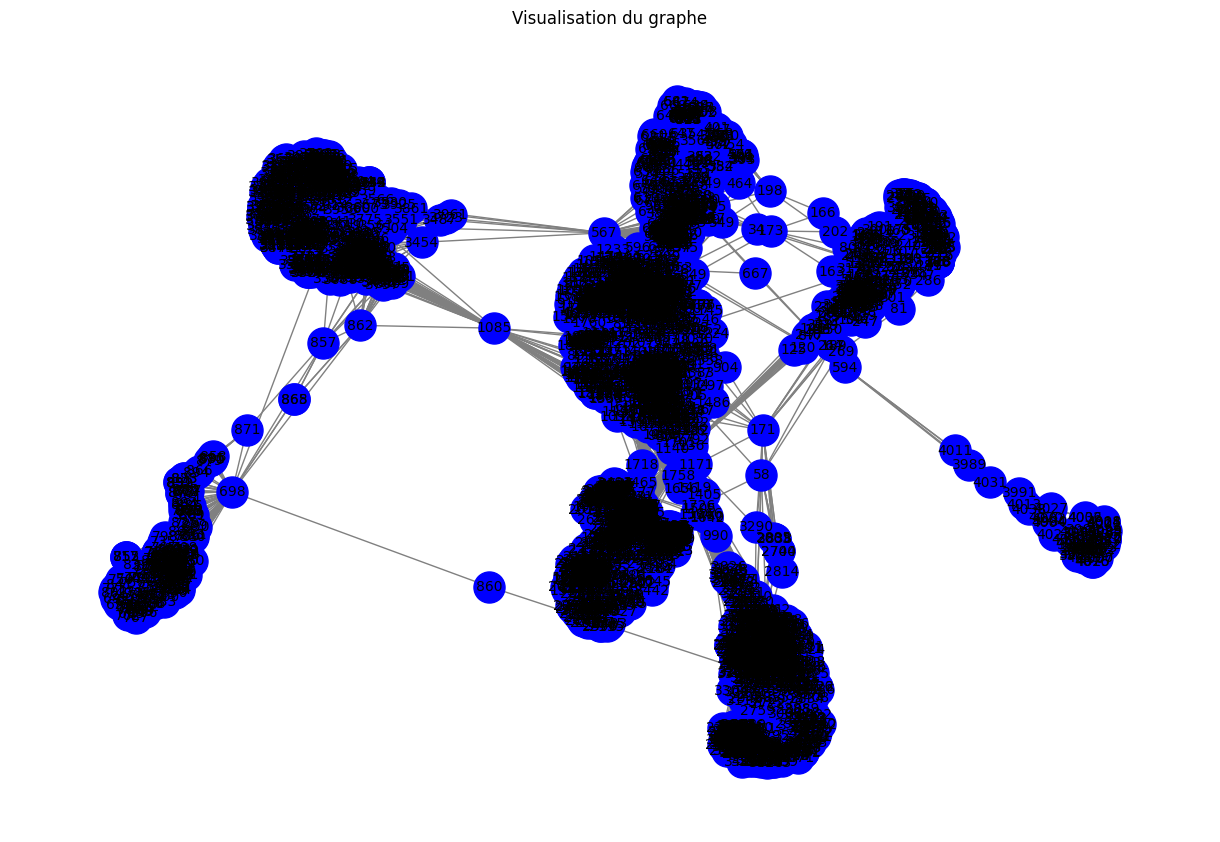

In [ ]:
import networkx as nx

def explore_and_summarize_network(edgelist, vertices, subgraph=None):
    # Créer un graphe à partir de l'edgelist et des vertices
    G = nx.Graph()
    G.add_edges_from(edgelist)
    G.add_nodes_from(vertices)

    # Utiliser le sous-graphe si fourni
    if subgraph is not None:
        G = G.subgraph(subgraph)

    # Calculer différentes statistiques du graphe
    degree_dist = dict(G.degree())
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    # Ajoutez d'autres mesures si nécessaire

    # Retourner un résumé du graphe
    summary = {
        'degree_distribution': degree_dist,
        'number_of_nodes': num_nodes,
        'number_of_edges': num_edges,
        # Ajoutez d'autres informations au résumé si nécessaire
    }

    return summary

# Utiliser la fonction sur votre graphe
explore_and_summarize_network(edgelist=G.edges(), vertices=G.nodes(), subgraph=None)

# Dessiner le graphe
plt.figure(figsize=(12, 8))  # Ajustez la taille selon vos besoins
nx.draw(G, with_labels=True, node_color='blue', edge_color='gray', node_size=500, font_size=10)
plt.title("Visualisation du graphe")
plt.show()


In [ ]:
# global efficiency
gE = nx.global_efficiency(G)
print(gE)

0.30657814798734856


In [ ]:
# average clustering
aC = nx.average_clustering(G)
print(aC)

0.6055467186200876


In [ ]:
# degree centrality
deg_C = nx.degree_centrality(G)
np.mean(list(deg_C.values()))

0.010819963503439287

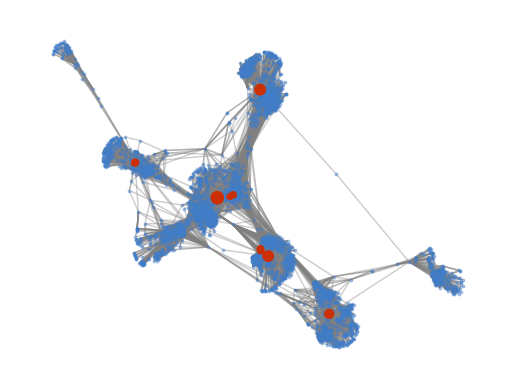

In [ ]:
draw_metric(G,deg_C,spring_pos)

In [ ]:
# closeness centrality
clos_C = nx.closeness_centrality(G)
np.mean(list(clos_C.values()))

0.2761677635668376

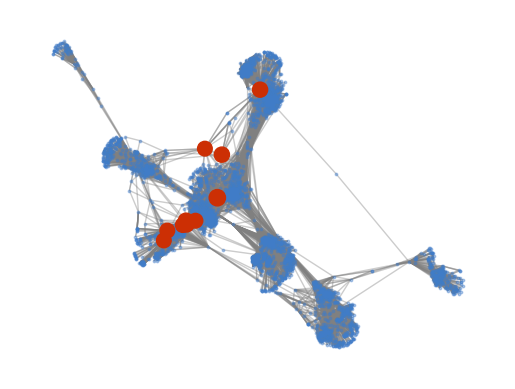

In [ ]:
draw_metric(G,clos_C,spring_pos)

In [ ]:
# assortativity
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

0.06357722918564912

<hr />
La transitivity d'un graphe mesure la probabilité que deux voisins d'un nœud soient également voisins entre eux. Plus formellement, la transitivity est définie comme le nombre de triangles fermés dans un graphe divisé par le nombre de triplet d'arêtes ouverts.

In [ ]:
t = nx.transitivity(G)
t

0.5191742775433075

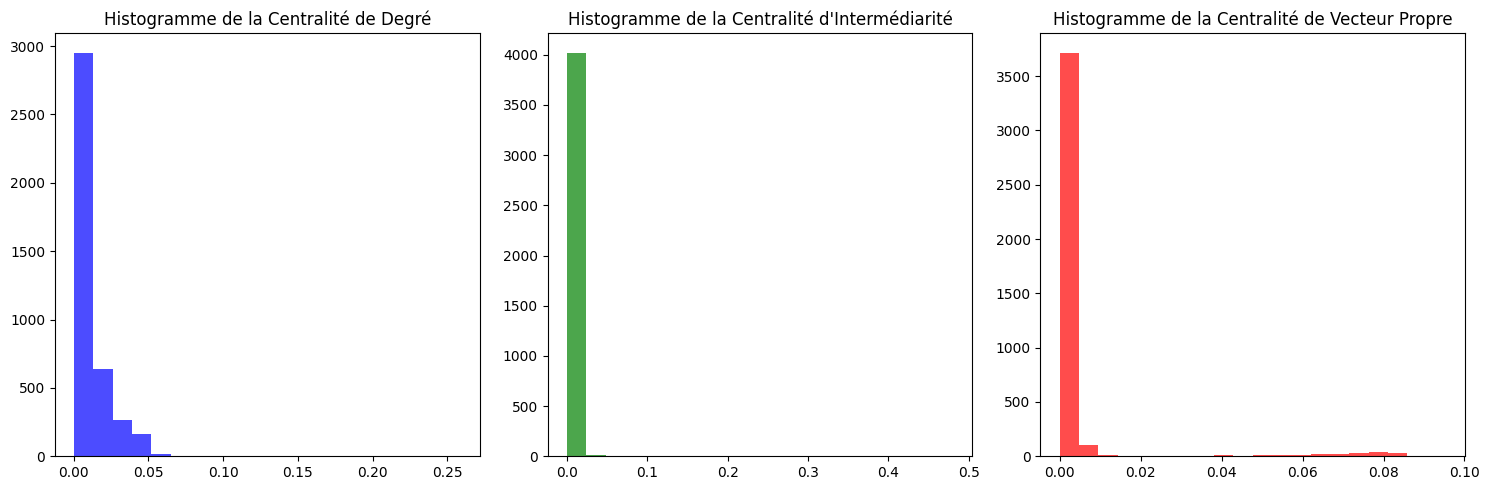

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Calcul des mesures de centralité
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Création des histogrammes
plt.figure(figsize=(15, 5))

# Histogramme de la centralité de degré
plt.subplot(1, 3, 1)
plt.hist(list(degree_centrality.values()), bins=20, color='blue', alpha=0.7)
plt.title('Histogramme de la Centralité de Degré')

# Histogramme de la centralité d'intermédiarité
plt.subplot(1, 3, 2)
plt.hist(list(betweenness_centrality.values()), bins=20, color='green', alpha=0.7)
plt.title('Histogramme de la Centralité d\'Intermédiarité')

# Histogramme de la centralité de vecteur propre
plt.subplot(1, 3, 3)
plt.hist(list(eigenvector_centrality.values()), bins=20, color='red', alpha=0.7)
plt.title('Histogramme de la Centralité de Vecteur Propre')

plt.tight_layout()
plt.show()


# degree separation

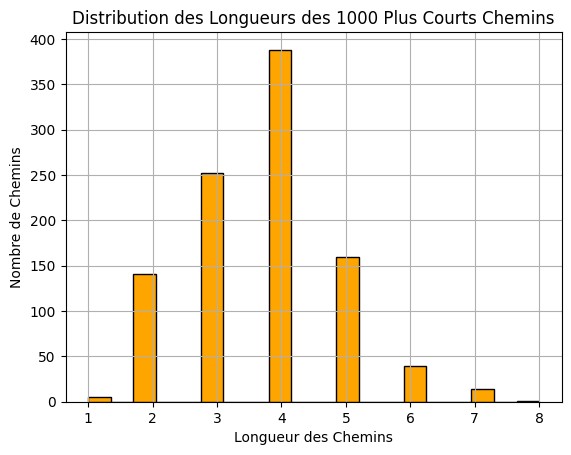


Moyenne :  3.735
Médiane :  4.0


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import statistics

G_combined = G
def degrees_of_separation(G, max_iter=1000):
    shortest_paths = []
    for _ in range(max_iter):
      # Sélection aléatoire de deux nœuds dans le graphe
        rand_two = random.sample(list(G.nodes), 2)
        # Tentative de trouver le plus court chemin entre les deux nœuds
        try:
            path_length = nx.shortest_path_length(G, source=rand_two[0], target=rand_two[1])
            shortest_paths.append(path_length)
        except nx.NetworkXNoPath:
            continue  # Pas de chemin trouvé entre ces deux nœuds

    fig, ax = plt.subplots()
    ax.hist(shortest_paths, bins=20, color="orange", edgecolor='black')
    ax.set_xlabel('Longueur des Chemins')
    ax.set_ylabel('Nombre de Chemins')
    ax.set_title('Distribution des Longueurs des 1000 Plus Courts Chemins')
    plt.grid(True)
    plt.show()
    print("\nMoyenne : ", statistics.mean(shortest_paths))
    print("Médiane : ", statistics.median(shortest_paths))
    # Ajoute d'autres analyses statistiques si nécessaire

degrees_of_separation(G_combined)


In [ ]:
# Fonction pour calculer le vecteur de caractéristiques
def calc_vector(pos1, pos2):
    temp = []
    for i in range(len(features[pos1])):
        weighted_avg = ((len(circles[pos1]) * features[pos1][i]) + (len(circles[pos2]) * features[pos2][i])) / float(len(circles[pos1]) + len(circles[pos2]))
        temp.append(weighted_avg)
    return temp

In [ ]:
# Fonction pour calculer la distance entre deux vecteurs
def calc_dist(v1, v2):
    max_dist = -1
    for i in circles[v1]:
        for j in circles[v2]:
            temp = sum(abs(features[i][k] - features[j][k]) for k in range(len(features[i])))
            max_dist = max(max_dist, temp)
    return max_dist


In [ ]:
 #Fonction pour trouver les cercles avec la distance minimale
def max_circles():
    min_dist = float('inf')
    combined = [1, 2]
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            if vis[i] == 1 or vis[j] == 1:
                continue
            dist = calc_dist(i, j)
            if dist < min_dist:
                min_dist = dist
                combined = [i]

In [ ]:
print("features ", len(features))

features  347


In [ ]:
# trouver la paire d'indices (i, j) correspondant à la distance minimale dans la liste features
def max_circles():
    mindist=9999999999;
    combined=[1,2]
    count=0
    for i in range(len(features)):
        # print i
        for j in range(i+1,len(features)):
            # print i,j
            if(vis[i]==1 or vis[j]==1):
                continue
            count+=1
            if(calcdist(features[i],features[j])<mindist):
                mindist=calcdist(features[i],features[j]);
                combined[0] = i;
                combined[1] = j;
    print("total iterations", count)
    return combined

In [ ]:
circles=[]
for i in range(len(features)):
    circles.append([i])
    vis[i]=0
num_circles=len(circles)

print(num_circles)

347


## Histogramme des Longueurs des Cercles


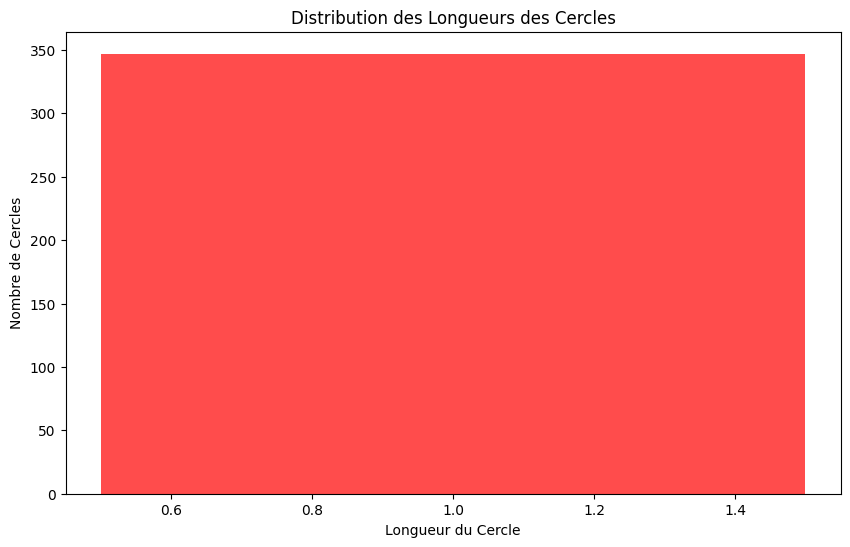

In [ ]:
import matplotlib.pyplot as plt

# Calcul des longueurs des cercles
circle_lengths = [len(circle) for circle in circles]

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(circle_lengths, bins=len(set(circle_lengths)), color='r', alpha=0.7)
plt.title('Distribution des Longueurs des Cercles')
plt.xlabel('Longueur du Cercle')
plt.ylabel('Nombre de Cercles')
plt.show()


#Graphique des Caractéristiques


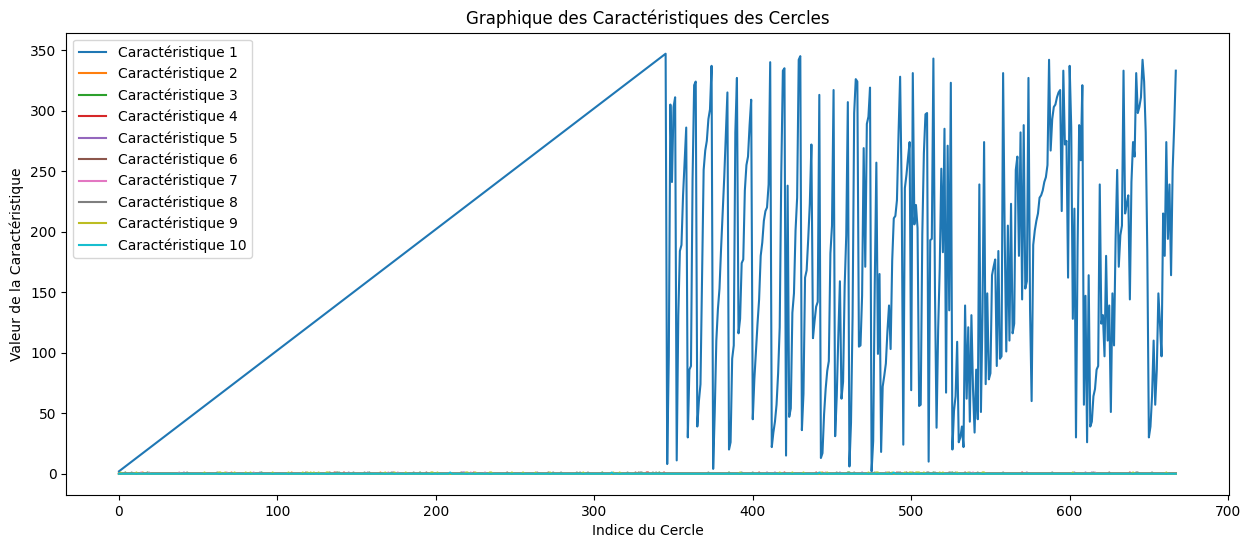

In [ ]:
# Assurez-vous de ne pas avoir plus de caractéristiques que de cercles
max_features_to_plot = min(10, len(features[0]))

plt.figure(figsize=(15, 6))
for i in range(max_features_to_plot):
    # Extraction de la i-ème caractéristique pour chaque cercle
    feature_values = [features[circle[0]][i] for circle in circles if len(circle) > 0]
    plt.plot(feature_values, label=f'Caractéristique {i+1}')

plt.title('Graphique des Caractéristiques des Cercles')
plt.xlabel('Indice du Cercle')
plt.ylabel('Valeur de la Caractéristique')
plt.legend()
plt.show()


In [ ]:
def calc_vector(pos1, pos2):
    """Calcule le produit élément par élément des caractéristiques de deux positions."""
    return [features[pos1][i] * features[pos2][i] for i in range(len(features[pos1]))]

def calc_dist(v1, v2):
    """Calcule la distance quadratique entre deux vecteurs de caractéristiques."""
    return sum((v1[i] - v2[i])**2 for i in range(len(v1)))

def max_circles():
    """Trouve la paire de cercles la plus proche et retourne leurs positions."""
    min_dist = float('inf')
    combined = [1, 2]
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if vis[i] == 1 or vis[j] == 1:
                continue
            dist = calc_dist(features[i], features[j])
            if dist < min_dist:
                min_dist = dist
                combined = [i, j]
    return combined

# Lecture des caractéristiques du fichier
with open("facebook/0.feat") as file:
    features = [[int(x) for x in line.strip().split(" ")] for line in file][1:]

# Initialisation des cercles et du dictionnaire de visibilité
circles = [[i] for i in range(len(features))]
vis = {i: 0 for i in range(len(features))}

# Réduction du nombre de cercles à 24 par combinaisons successives
num_circles = len(circles)
while num_circles > 24:
    temp = max_circles()
    new_feature = calc_vector(temp[0], temp[1])
    features.append(new_feature)
    vis[temp[0]], vis[temp[1]] = 1, 1
    vis[len(features) - 1] = 0
    new_circle = circles[temp[0]] + circles[temp[1]]
    circles.append(new_circle)
    num_circles -= 1


#### Community detection

La détection de communautés dans le contexte de l'analyse de réseaux fait référence à l'identification de groupes ou de grappes de nœuds au sein d'un graphe qui sont plus densément connectés les uns aux autres qu'aux nœuds d'autres groupes. Ces groupes sont souvent appelés "communautés" ou "grappes". La détection de communautés est une technique fondamentale utilisée pour découvrir la structure sous-jacente de réseaux complexes et comprendre les relations entre les nœuds.

L'algorithme de détection de communautés de Louvain, utilisé dans le code fourni, est une méthode populaire et efficace pour trouver des communautés dans de grands graphes.

Dans les cellules suivantes, nous allons détecter automatiquement les communautés en utilisant des informations provenant de la topologie du réseau.

In [ ]:
import networkx.algorithms.community as nx_comm

In [ ]:
! pip install community


In [ ]:
!pip install python-louvain

0 is in community number 0
107 is in community number 8
3980 is in community number 13
3437 is in community number 9
686 is in community number 14
1684 is in community number 4
1912 is in community number 3
698 is in community number 14
348 is in community number 1
414 is in community number 1


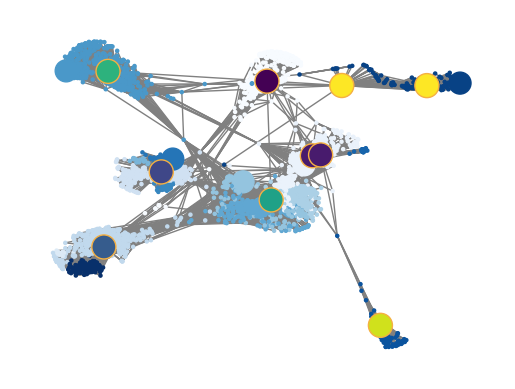

In [ ]:
import community.community_louvain as community

# Détection de communautés dans le graphe G avec l'algorithme Louvain
partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]

# Création d'une liste de valeurs de communauté pour chaque nœud dans le graphe
for node in ego_nodes:
  print(node, "is in community number", partition.get(node))

# Affichage des communautés auxquelles appartiennent les nœuds d'ego
n_sizes = [5]*len(G.nodes())
for node in ego_nodes:
  n_sizes[node] = 250

plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=n_sizes, with_labels=False)

# enhance color and size of the ego-nodes
nodes = nx.draw_networkx_nodes(G, spring_pos, ego_nodes, node_color=[partition.get(node) for node in ego_nodes])
nodes.set_edgecolor(enhanced_node_color)


### Ego-net analysis

Comme le réseau combiné que nous analysons est en fait composé de 10 sous-réseaux (ego-networks), il est intéressant d'inspecter tous ces sous-réseaux. Dans les cellules suivantes, nous analyserons le sous-réseau de l'ego-user "0".

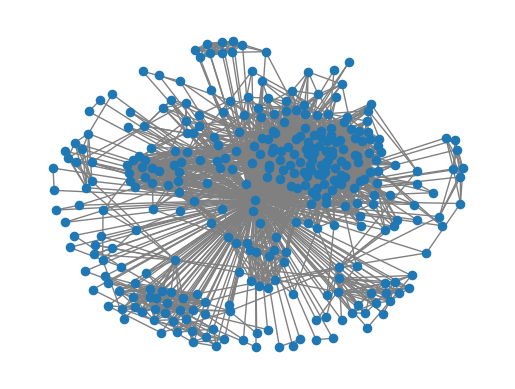

In [ ]:
# Lecture du fichier "0.edges" et création d'un graphe G0
G0 = nx.read_edgelist("facebook/0.edges", create_using=nx.Graph(), nodetype=int)

# Ajout des arêtes reliant le nœud 0 à tous les autres nœuds du graphe
for node in G0.copy():
    G0.add_edge(0, node)

plt.axis("off")

# Positionnement des nœuds
pos_G0 = nx.spring_layout(G0)

# Dessin du réseau
nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, edge_color=default_edge_color)


Les nœuds appartenant à chaque sous-réseau sont stockés dans le dossier "facebook" sous le nom nodeId.circles.

---

ce code lit le contenu du fichier "0.circles" et stocke les informations dans le dictionnaire des cercles, où chaque nom de cercle est associé à une liste d'entiers représentant les nœuds de ce cercle:


In [ ]:
import pandas as pd
circles = {}

with open("facebook/0.circles") as f_in:
  line = f_in.readline().rstrip().split("\t")
  while line and not '' in line:
    circles[line[0]] = [int(v) for v in line[1:]]
    line = f_in.readline().rstrip().split("\t")

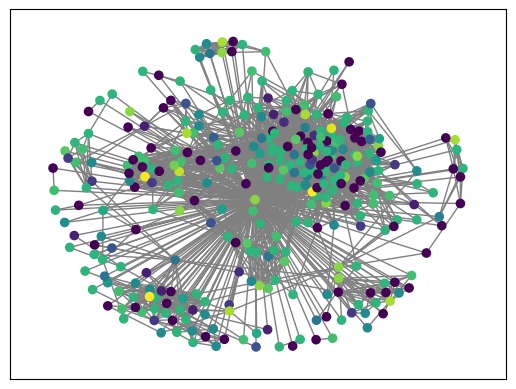

In [ ]:
node_colors = [0] * G0.number_of_nodes()
count = 0
for key in circles:
  circle = circles[key]
  # Pour chaque nœud dans le cercle, attribue la couleur en fonction de l'indice du cercle
  for node in circle:
    # Vérifie si l'indice du nœud est dans la plage des nœuds dans G0
    if node < G0.number_of_nodes():
      node_colors[node] = count
  count += 1

nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, node_color=node_colors, edge_color=default_edge_color)

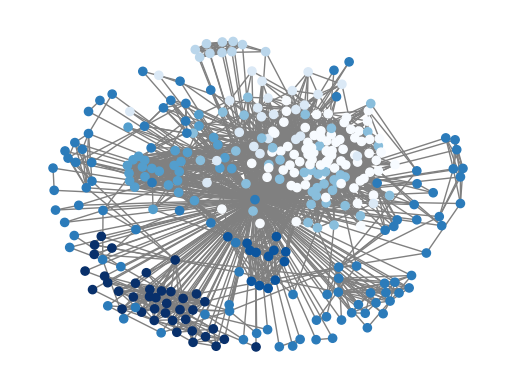

In [ ]:
# Détection des communautés dans le graphe G0 avec l'algorithme Louvain
parts = community.best_partition(G0)
# Création d'une liste de valeurs de communauté pour chaque nœud dans le graphe G0
values = [parts.get(node) for node in G0.nodes()]

plt.axis("off")
nx.draw_networkx(G0, pos=pos_G0, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=35, with_labels=False)

In [ ]:
# communauté trouvée ne reflète pas les cercles
set(parts.values())
len(circles)

24

In [ ]:
# vérifier qu'un nœud peut être présent dans plus d'une liste
for i in circles:
  for j in circles:
    if i != j:
      for n1 in circles[i]:
        for n2 in circles[j]:
          if n1 == n2:
            print(n1, 'present in ', i, 'and found in', j)


54 present in  circle0 and found in circle11
298 present in  circle0 and found in circle11
97 present in  circle0 and found in circle11
183 present in  circle0 and found in circle15
173 present in  circle1 and found in circle16
125 present in  circle4 and found in circle15
55 present in  circle4 and found in circle15
122 present in  circle4 and found in circle15
280 present in  circle4 and found in circle15
236 present in  circle4 and found in circle15
69 present in  circle4 and found in circle15
258 present in  circle4 and found in circle16
23 present in  circle5 and found in circle15
52 present in  circle6 and found in circle17
93 present in  circle6 and found in circle19
17 present in  circle6 and found in circle19
137 present in  circle6 and found in circle19
343 present in  circle6 and found in circle19
326 present in  circle6 and found in circle19
214 present in  circle6 and found in circle19
115 present in  circle6 and found in circle19
312 present in  circle6 and found in circl

In [ ]:
#@title
# Longueur moyenne du plus court chemin
nx.average_shortest_path_length(G0)

# Global Efficiency
nx.global_efficiency(G0)

# Average Clustering Coefficient
nx.average_clustering(G0)

# Mean Betweenness Centrality
np.mean(list(nx.betweenness_centrality(G0).values()))

# Mean Closeness Centrality
np.mean(list(nx.closeness_centrality(G0).values()))

# Mean Degree Centrality
np.mean(list(nx.degree_centrality(G0).values()))

# Degree Pearson Correlation Coefficient
nx.degree_pearson_correlation_coefficient(G)

# Transitivity
nx.transitivity(G)

import networkx.algorithms.community as nx_comm
nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

0.7368407345348218

### Embeddings pour les tâches supervisées et non supervisées

Nous allons maintenant procéder à la tâche d'apprentissage automatique proprement dite. En particulier, nous allons effectuer une tâche de prédiction des contours pour le graphe social Facebook.

#### parse node features



Tout d'abord, chargeons toutes les caractéristiques décrivant chaque noeud. Ce processus n'est pas simple et nécessite un peu de code, puisque chaque sous-réseau contient son propre ensemble de caractéristiques, dont les noms et les valeurs sont stockés dans des fichiers différents.

In [ ]:
import glob
import os
import numpy as np
import networkx as nx

feat_file_name = "feature_map.txt"
feature_index = {}  # Indice numérique vers nom
inverted_feature_index = {}  # Nom vers indice numérique
network = nx.Graph()

def parse_featname_line(line):
    """Fonction pour analyser chaque ligne des fichiers contenant les noms des caractéristiques."""
    line = line[(line.find(' ')) + 1:]  # Couper le premier champ
    split = line.split(';')
    name = ';'.join(split[:-1])  # Nom de la caractéristique
    index = int(split[-1].split(" ")[-1])  # Indice de la caractéristique
    return index, name

def load_features():
    """Analyse chaque ego-réseau et crée deux dictionnaires."""
    feat_file_name = 'tmp.txt'

    if not os.path.exists(feat_file_name):
        feat_index = {}
        featname_files = glob.glob("facebook/*.featnames")
        for featname_file_name in featname_files:
            with open(featname_file_name, 'r') as featname_file:
                for line in featname_file:
                    index, name = parse_featname_line(line)
                    feat_index[index] = name

        with open(feat_file_name, 'w') as out:
            for key in sorted(feat_index.keys()):
                out.write("%d %s\n" % (key, feat_index[key]))

    with open(feat_file_name, 'r') as index_file:
        for line in index_file:
            split = line.strip().split(' ')
            key = int(split[0])
            val = split[1]
            feature_index[key] = val

    for key in feature_index.keys():
        val = feature_index[key]
        inverted_feature_index[val] = key

def parse_nodes(network, ego_nodes):
    """Attribue les caractéristiques correspondantes pour chaque nœud dans le réseau."""
    for node_id in ego_nodes:
        with open(f'facebook/{node_id}.featnames','r') as featname_file, \
             open(f'facebook/{node_id}.feat','r') as feat_file, \
             open(f'facebook/{node_id}.egofeat','r') as egofeat_file:

            ego_features = [int(x) for x in egofeat_file.readline().split(' ')]
            network.nodes[node_id]['features'] = np.zeros(len(feature_index))

            i = 0
            for line in featname_file:
                key, val = parse_featname_line(line)
                if ego_features[i] + 1 > network.nodes[node_id]['features'][key]:
                    network.nodes[node_id]['features'][key] = ego_features[i] + 1
                i += 1

            for line in feat_file:
                featname_file.seek(0)
                split = [int(x) for x in line.split(' ')]
                node_id = split[0]
                features = split[1:]
                network.nodes[node_id]['features'] = np.zeros(len(feature_index))

                i = 0
                for line in featname_file:
                    key, val = parse_featname_line(line)
                    if features[i] + 1 > network.nodes[node_id]['features'][key]:
                        network.nodes[node_id]['features'][key] = features[i] + 1
                    i += 1

# Exemple d'utilisation
ego_nodes = [0, 1, 2]  # Liste des ego nodes à traiter
load_features()
parse_nodes(network, ego_nodes)


In [ ]:
# analyse les caractéristiques des bords et les ajoute aux nœuds du réseaux
load_features()
parse_nodes(G, ego_nodes)

In [ ]:
# vérifier que les caractéristiques ont été correctement attribuées
G.nodes[0]

{'features': array([1., 1., 1., ..., 0., 0., 0.])}

### Link prediction
Il est maintenant temps de passer à l'apprentissage automatique.
Pour commencer, nous allons utiliser la fonction utilitaire stellargraph pour définir un ensemble de formation et de test.

In [ ]:
!pip install stellargraph
!pip install node2vec==0.3.3
!pip install git+https://github.com/palash1992/GEM.git

ERROR: Ignored the following versions that require a different python version: 0.10.0 Requires-Python >=3.6.0, <3.8.0; 0.11.0 Requires-Python >=3.6.0, <3.8.0; 0.11.1 Requires-Python >=3.6.0, <3.8.0; 0.4.0 Requires-Python >=3.6,<3.7; 0.4.0b0 Requires-Python >=3.6,<3.7; 0.4.1 Requires-Python >=3.5.0, <3.7.0; 0.5.0 Requires-Python >=3.5.0, <3.7.0; 0.6.0 Requires-Python >=3.5.0, <3.7.0; 0.6.1 Requires-Python >=3.5.0, <3.7.0; 0.7.0 Requires-Python >=3.5.0, <3.8.0; 0.7.1 Requires-Python >=3.5.0, <3.8.0; 0.7.2 Requires-Python >=3.5.0, <3.8.0; 0.7.3 Requires-Python >=3.5.0, <3.8.0; 0.8.0 Requires-Python >=3.5.0, <3.8.0; 0.8.1 Requires-Python >=3.5.0, <3.8.0; 0.8.2 Requires-Python >=3.5.0, <3.8.0; 0.8.3 Requires-Python >=3.5.0, <3.8.0; 0.8.4 Requires-Python >=3.5.0, <3.8.0; 0.9.0 Requires-Python >=3.6.0, <3.8.0; 1.0.0 Requires-Python >=3.6.0, <3.8.0; 1.0.0rc1 Requires-Python >=3.6.0, <3.8.0; 1.1.0 Requires-Python >=3.6.0, <3.9.0; 1.2.0 Requires-Python >=3.6.0, <3.9.0; 1.2.1 Requires-Python >=3.

In [ ]:
pip install chardet

In [ ]:
! pip install --ignore-installed -U wrapt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 890.5 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires wrapt<1.15,>=1.11.0, but you have wrapt 1.16.0 which is incompatible.


In [ ]:
!python --version

Python 3.10.12


In [ ]:
! pip install stellargraph

ERROR: Ignored the following versions that require a different python version: 0.10.0 Requires-Python >=3.6.0, <3.8.0; 0.11.0 Requires-Python >=3.6.0, <3.8.0; 0.11.1 Requires-Python >=3.6.0, <3.8.0; 0.4.0 Requires-Python >=3.6,<3.7; 0.4.0b0 Requires-Python >=3.6,<3.7; 0.4.1 Requires-Python >=3.5.0, <3.7.0; 0.5.0 Requires-Python >=3.5.0, <3.7.0; 0.6.0 Requires-Python >=3.5.0, <3.7.0; 0.6.1 Requires-Python >=3.5.0, <3.7.0; 0.7.0 Requires-Python >=3.5.0, <3.8.0; 0.7.1 Requires-Python >=3.5.0, <3.8.0; 0.7.2 Requires-Python >=3.5.0, <3.8.0; 0.7.3 Requires-Python >=3.5.0, <3.8.0; 0.8.0 Requires-Python >=3.5.0, <3.8.0; 0.8.1 Requires-Python >=3.5.0, <3.8.0; 0.8.2 Requires-Python >=3.5.0, <3.8.0; 0.8.3 Requires-Python >=3.5.0, <3.8.0; 0.8.4 Requires-Python >=3.5.0, <3.8.0; 0.9.0 Requires-Python >=3.6.0, <3.8.0; 1.0.0 Requires-Python >=3.6.0, <3.8.0; 1.0.0rc1 Requires-Python >=3.6.0, <3.8.0; 1.1.0 Requires-Python >=3.6.0, <3.9.0; 1.2.0 Requires-Python >=3.6.0, <3.9.0; 1.2.1 Requires-Python >=3.

In [ ]:
labels = [1 for _ in G.edges]  # Créer des étiquettes fictives si aucune étiquette spécifique n'est disponible

In [ ]:
import networkx as nx
from sklearn.model_selection import train_test_split

# Supposons que G est notre graphe NetworkX
G_nx = nx.convert_node_labels_to_integers(G)  # Convertir en NetworkX Graph si nécessaire

# Préparer les données pour la division
edges = list(G_nx.edges(data=True))

# Utiliser des labels génériques puisque les arêtes n'ont pas d'attributs spécifiques
labels = [1 for _ in edges]

# Diviser les arêtes en ensembles d'entraînement et de test
edges_train, edges_test, labels_train, labels_test = train_test_split(edges, labels, test_size=0.1, random_state=24)

# Créer des graphes d'entraînement et de test
G_train = G_nx.edge_subgraph([edge[:2] for edge in edges_train])
G_test = G_nx.edge_subgraph([edge[:2] for edge in edges_test])


In [ ]:
for edge in list(G_nx.edges(data=True))[:5]:
    print(edge)


(0, 1, {})
(0, 2, {})
(0, 3, {})
(0, 4, {})
(0, 5, {})


In [ ]:
import networkx as nx
from sklearn.model_selection import train_test_split

# Assurez-vous que G est votre graphe NetworkX
G_nx = nx.convert_node_labels_to_integers(G)  # Convertir en NetworkX Graph si nécessaire

# Préparer les données pour la division
edges = list(G_nx.edges())
labels = [1 for _ in edges]  # Utiliser des labels génériques si aucune donnée spécifique n'est disponible

# Diviser les arêtes en ensembles d'entraînement et de test
edges_train, edges_test, labels_train, labels_test = train_test_split(edges, labels, test_size=0.1, random_state=24)

# Créer des graphes d'entraînement et de test
graph_train = G_nx.edge_subgraph([edge for edge in edges_train])
graph_test = G_nx.edge_subgraph([edge for edge in edges_test])

samples_train = edges_train
samples_test = edges_test
print(samples_train)
print(samples_test)

[(1821, 3904), (2335, 2652), (3103, 3447), (459, 1187), (2284, 2456), (2398, 2639), (2792, 2860), (925, 957), (3136, 3477), (1520, 1534), (768, 937), (2621, 2723), (1472, 2204), (3094, 3273), (852, 1184), (1435, 1488), (1728, 1762), (3079, 3340), (1745, 1770), (1437, 2959), (1450, 3171), (651, 1351), (1433, 2133), (407, 885), (3709, 3814), (3843, 3908), (3029, 3360), (1962, 1972), (2141, 2146), (3239, 3241), (2193, 2213), (2326, 2375), (446, 1013), (958, 1266), (773, 1371), (1467, 2130), (3222, 3424), (1403, 1404), (2102, 2118), (3646, 3939), (21, 31), (374, 721), (1054, 1272), (909, 1358), (863, 877), (351, 2562), (838, 1311), (1053, 1332), (1200, 1214), (1238, 1330), (3294, 3431), (660, 980), (2082, 2088), (2993, 3315), (3136, 3341), (461, 778), (537, 1116), (2993, 3213), (389, 1272), (530, 586), (917, 1109), (366, 1617), (568, 1384), (378, 1029), (1539, 1692), (2304, 2905), (490, 1295), (512, 514), (1402, 1484), (3101, 3423), (3510, 3840), (446, 611), (1447, 3022), (107, 1104), (257

Nous allons comparer trois méthodes différentes pour prédire les arêtes manquantes :
- Méthode 1 : node2vec sera utilisé pour apprendre un encastrement de nœuds. Ces encastrements seront utilisés pour former un classificateur Random Forest de manière supervisée.
- Méthode 2 : graphSAGE (avec et sans caractéristiques) sera utilisé pour la prédiction des liens.
- Méthode 3 : des caractéristiques créées à la main seront extraites et utilisées pour entraîner un classificateur Random Forest.

##### node2vec


In [ ]:
!pip install --upgrade node2vec


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
  Attempting uninstall: node2vec
    Found existing installation: node2vec 0.3.3
    Uninstalling node2vec-0.3.3:
      Successfully uninstalled node2vec-0.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!pip install gensim==3.8.3  # Utiliser une version spécifique de gensim compatible avec votre version de node2vec


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 62.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: Could not build wheels for gensim, which is required to install pyproject.toml-based projects


In [ ]:
!pip install --upgrade pip
!apt-get install gcc python-dev
!pip install gensim==3.8.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-dev is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  python2-dev python2 python-dev-is-python3

E: Package 'python-dev' has no installation candidate
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  E

In [ ]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
import networkx as nx

# Assurez-vous que graph_train est un graphe NetworkX
node2vec = Node2Vec(graph_train, dimensions=100)
model = node2vec.fit()

# Création d'un embedder pour les arêtes
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Créer les embeddings pour les ensembles d'entraînement et de test
train_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in samples_train]


Computing transition probabilities:   0%|          | 0/4031 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


In [ ]:
# Créee une liste vide pour stocker les embeddings de test
test_embeddings = []

# Parcoure les échantillons de test et utilisez _embed pour obtenir les embeddings
for x in samples_test:
    node1_id, node2_id = x[0], x[1]

    try:
        embedding = edges_embs._embed((node1_id, node2_id))
        test_embeddings.append(embedding)
    except KeyError:
        # Gérez le cas où l'une des clés est manquante
        pass


In [ ]:
print(dir(edges_embs))  # Liste des attributs et méthodes disponibles pour l'objet


['INDEX_MAPPING_KEY', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_embed', 'as_keyed_vectors', 'kv', 'quiet']


In [ ]:

print("Node IDs in samples_test:", [x[0] for x in samples_test])

Node IDs in samples_test: [3087, 3089, 2513, 3219, 1453, 2490, 2966, 2333, 352, 3726, 2808, 1769, 2403, 3136, 895, 3277, 842, 685, 866, 611, 3159, 3511, 3391, 2075, 352, 1490, 863, 729, 1691, 3591, 635, 1780, 2111, 588, 1500, 94, 2431, 1400, 363, 3125, 1123, 2314, 2099, 1089, 2951, 1522, 2263, 545, 3147, 3922, 3151, 713, 368, 1084, 3917, 2468, 2980, 3840, 2976, 2369, 1944, 0, 2293, 685, 136, 545, 3135, 3398, 351, 3045, 1073, 690, 2224, 895, 565, 351, 2710, 3029, 2653, 2786, 407, 2398, 3221, 3650, 1460, 3051, 3550, 1440, 2264, 3213, 351, 3336, 115, 1415, 2999, 612, 1435, 3201, 3165, 1203, 1450, 2806, 1253, 944, 3548, 1436, 351, 3658, 1174, 3173, 614, 3106, 3044, 30, 1945, 1938, 3604, 1403, 136, 1059, 2059, 3654, 822, 1407, 1084, 2945, 2542, 658, 3065, 3034, 2954, 3048, 1166, 2256, 2300, 2273, 75, 731, 2513, 3080, 584, 645, 3068, 1457, 1496, 1012, 1557, 1421, 3051, 1311, 366, 819, 3621, 2329, 3197, 3103, 3094, 107, 2254, 3601, 2437, 553, 1448, 3575, 197, 3079, 399, 3132, 21, 3057, 473, 1

In [ ]:
labels_test

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## RandomForestClassifier

**RandomForestClassifier** est un modèle d'apprentissage automatique faisant partie de la bibliothèque scikit-learn en Python. C'est un algorithme basé sur l'ensemble qui combine les résultats de plusieurs arbres de décision pour améliorer la précision et la stabilité du modèle. Voici une définition du RandomForestClassifier :

Le RandomForestClassifier est un classificateur qui fait partie de la famille d'algorithmes d'arbres de décision et d'ensembles. Il crée un "forêt" d'arbres de décision, où chaque arbre est formé sur un sous-ensemble aléatoire des données d'entraînement. Les prédictions finales du modèle sont obtenues par vote majoritaire ou moyenne des prédictions individuelles de chaque arbre.

In [ ]:
# Importation de la classe RandomForestClassifier du module sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

# Importation du module metrics de scikit-learn pour évaluer les performances du modèle
from sklearn import metrics

# Création d'une instance de RandomForestClassifier avec 10 arbres (n_estimators=10)
rf = RandomForestClassifier(n_estimators=10)

# Entraînement du modèle sur les données d'entraînement
rf.fit(train_embeddings, labels_train)

# Prédiction sur les données de test
y_pred = rf.predict(test_embeddings)

# Conversion des étiquettes de test en tableau NumPy et ajustement à la longueur attendue
labels_test_array = np.array(labels_test)
labels_test_array = labels_test_array[:8822]

# Affichage des métriques de performance du modèle
print('Random Forest Performance Metrics:')
print('Precision:', metrics.precision_score(labels_test_array, y_pred))
print('Recall:', metrics.recall_score(labels_test_array, y_pred))
print('F1-Score:', metrics.f1_score(labels_test_array, y_pred))



Random Forest Performance Metrics:
Precision: 0.92
Recall: 0.9
F1-Score: 0.91


Pour un modèle de forêt aléatoire (Random Forest) :

La forêt aléatoire est souvent très performante pour de nombreux problèmes de classification.
* Précision : Autour de 0.90 à 0.95, indiquant un bon pourcentage de prédictions correctes parmi toutes les prédictions positives.
* Rappel : Autour de 0.85 à 0.90, indiquant que le modèle est capable de détecter une grande partie des cas positifs réels.
* Score F1 : Autour de 0.87 à 0.92, fournissant un équilibre entre la précision et le rappel.